# Applied Machine Learning: Summative Code 1/2 (Exploration)

**Candidate Number: 1047904**

**07 May, 2021**

<font color=red>**README:**</font> 

- Pre-processing and modelling was spread across two separate *Jupyter Notebooks* for performance reasons. 
- **To replicate reported analyses, both notebooks need to be in the same location as the data folder FFChallenge_v5 and run in the following sequence** 
1. Run notebook “CODE_Explore_1047904_Applied Machine Learning_Summative.ipynb" (this notebook) first to write out the pre-processed data and associated dytpe dictionary into *FFChallenge_v5* folder. 
2. Run notebook “CODE_Predict_1047904_Applied Machine Learning_Summative.ipynb" (the other notebook) second to pick up previously written out by the first notebook. This will allow you to re-run all prediction experiments

- In addition: **File FFMetadata_v07.csv needs be placed inside the FFChallenge_v5 folder before running any notebook**

## Library Imports

In [34]:
import pandas as pd
import numpy as np
from scipy import stats
from collections import Counter, defaultdict
import os
import pickle

import plotly.graph_objects as go
import seaborn as sns
import matplotlib.ticker as mticker
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches

import datetime
import time, math, re
import missingno as msno

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold
from sklearn.preprocessing import QuantileTransformer, quantile_transform
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing

from sklearn.metrics import median_absolute_error, r2_score
from sklearn.metrics import accuracy_score


from sklearn.linear_model import Lasso
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeCV
import statsmodels.api as sm
import lightgbm as lgb

%matplotlib inline

## Functions

In [35]:
def tag_col_dtype(df,dtype,metadata_df):
    """Flag columns as either continuous or categorical based on metadata categorization"""

    col_names_meta = set(metadata_df.loc[metadata_df.type == dtype,'new_name'].tolist() + metadata_df.loc[metadata_df.type == dtype,'old_name'].tolist())
    col_names_data = set(df.columns.tolist())
    col_names_intersect = col_names_meta.intersection(col_names_data)
    
    print("=="*2 + f" Looking for {dtype} in data ... " + "=="*2,"\n")
    
    print(f"{len(col_names_meta)} Cols of dtype" + "\033[1m" + f" {dtype}" + "\033[0m" + " (Old & New names) in metadata")
    print(f"{len(col_names_intersect)} Cols of dtype" + "\033[1m" + f" {dtype} " + "\033[0m" + "in the intersection")
    
    dtypes_intersect = df.loc[:,col_names_intersect].dtypes

    
    if dtype in cont_group:
        
        conflict_cols = dtypes_intersect[dtypes_intersect.map(lambda x: x in [np.dtype("O")])].index
        
    
        rename_dict = {col : f"CONT_{col}" for col in col_names_intersect}
        
        df  = df.rename(columns=rename_dict)
        
        print(f"These {len(col_names_intersect)} Cols classify as" + "\033[1m" + " Continuous >  add CONT_ prefix to Col names"  +"\033[0m")
        print(f"{len(conflict_cols )} Cols with conflicting dtype relative to metadata")
        
    if dtype in cat_group:
        
        conflict_cols = dtypes_intersect[dtypes_intersect.map(lambda x: x in [np.dtype("O")])].index
        
        rename_dict = {col : f"CAT_{col}" for col in col_names_intersect}
        
        print(f"These {len(col_names_intersect)} Cols classify as" + "\033[1m" + " Categorical >  add CAT_ prefix to Col names"  +"\033[0m")
        print(f"{len(conflict_cols )} Cols with non-numeric dtypes")
        
        df = df.rename(columns=rename_dict)
    print("")
    print("**"*2 +" dtype distribution in intersection " + "**"*2,dtypes_intersect.value_counts(),"\n",sep="\n")
    
    return df, col_names_intersect, conflict_cols


def investigate_missingness (df,verbose=False):
    """count missingness labels across columns in df"""
    
    #Capture total counts per missingness label category 
    total_missing_dict = Counter()
    
    #Capture amount of Cols a missingness label occurs
    var_level_missing_dict = Counter()
    missing_codes = [-1.0,-2.0,-3.0,-4.0,-5.0,-6.0,-7.0,-8.0,-9.0]
    
    counter = 0
    for col in df.columns[:]:
        
        if verbose:
            if counter % 2000 == 0 : print(f"{counter} variables checked for missingness... ") 
         
        missing_vals = [int(i) for i in df.loc[:,col] if (not isinstance(i,str) 
                                                   and not re.search(r'\d{4}-\d{2}-\d{2}',str(i))
                                                   and not re.search(r'[0-9]-[0-9]',str(i))
                                                   and not re.search(r'[0-9]:[0-9]',str(i))
                                                   and not re.search(r'<',str(i)))
                                                   and float(i) in missing_codes]
        
        total_missing_dict.update(missing_vals)
    
        var_level_missing_dict.update(set(missing_vals))
        
        counter += 1
    
    #Add regular "NaNs" as missingness category 
    total_missing_dict["NaN"] = df.isna().sum().sum() 
    
    return total_missing_dict,var_level_missing_dict


def similarity_check (df1,df2):
    """ evaluate similarity between two dataframes"""
    
    #Note: preclude NaNs becasue np.nan == np.nan evaluates to false
    print(f"df1 and df2 are equal: {df1.dropna().equals(df2.dropna())}")
    print(f"all dtype match: {df1.dtypes.equals(df2.dtypes)}")

    check_list = list()
    bad_cols = list()
    good_cols = list()
    
    for col1,col2 in zip(df1,df2):
        check_list.append(df1.loc[:,col1].dropna().equals(df2.loc[:,col2].dropna()))
        
        if not df1.loc[:,col1].dropna().equals(df2.loc[:,col2].dropna()):
            
            bad_cols.append(col1)
        else:
            good_cols.append(col1)
    
    print(f"Col-level appraisal: {len(bad_cols)} inconsistencies due to floating point inprecision")
    display(pd.Series(check_list).value_counts())
    
    return bad_cols,good_cols

## Load Datasets & complementary resources

In [36]:
#### Rectify import for background dataset
#
##retrive cols causing trouble during import 
#conf_cols = np.array([5168,5272,5328,5329,5340,5341,5351,5470,5479,5661,5663,5685,5695,5696,5706,5764,5772,5788,5803,5815,5816,5828,5900,5901,5937,5946,5965,5966,9287,12349,12353,12356])
#
##introduce offset to amend correct cols
#conf_cols = (conf_cols -1).tolist()
#
##convert col - dtype mapping into dict 
#dtype_bg ={background.columns[col]:str for col in conf_cols}
#
#### Rectify import for metadata dataset
#
##introduce offset to amend correct cols
#conf_cols = [4,12,22,23,26,46,50,54,58,62,66,70,74,78,82,86,90,94,98,102,106,110,114,118,122,126,130,134,138,142,146,150]
#
##convert col - dtype mapping into dict 
#dtype_md ={metadata_df.columns[col]:str for col in conf_cols}

dtype_md = {'group': str, 'scale': str,'probe': str,'qtext': str,'section': str,'label4': str,'label5': str,'label6': str,
 'label7': str,'label8': str,'label9': str,'label10': str,'label11': str,'label12': str,'label13': str,'label14': str,'label15': str,
 'label16': str,'label17': str,'label18': str,'label19': str,'label20': str,'label21': str,'label22': str,'label23': str,'label24': str,
 'label25': str,'label26': str,'label27': str,'label28': str,'label29': str,'label30': str}

dtype_bg = {'d3a23_a': str,'d3c5a_14ot': str,'d3c12_b1': str,'d3c12_b2': str,'d3c13a_9ot': str,'d3c14': str,'d3c14a_9ot': str,'d3g22a_9ot': str,'d3g23a_got': str,
 'r3a10_a5ot': str,'r3a10_a6ot': str, 'r3a17': str,'r3a17a_9ot': str,'r3a18': str,'r3a18a_9ot': str,'r3b13_a9ot': str,'r3b13b_9ot': str,'r3b21_a9ot': str,
 'r3b26_a': str,'r3b31a_a': str,'r3b31a_b': str,'r3b36_a': str, 'r3f7_a': str, 'r3f7_b': str,'r3f22_a9ot': str,'r3f23a_got': str,'r3f1_2': str, 'r3f2_2': str,
 'p4g20_ot': str,'ch5ppvtpr': str,'ch5wj9pr': str,'ch5wj10pr': str}

In [37]:
# Training Data - Features 
background = pd.read_csv('FFChallenge_v5/background.csv', sep=',', header=0, dtype=dtype_bg, index_col=0)

# Training Data - Dependent Variables
train = pd.read_csv('FFChallenge_v5/train.csv', sep=',', header=0, index_col=0)

# Constant Features (for removal)
constantVariables = pd.read_csv('FFChallenge_v5/constantVariables.txt',header=None, index_col=0)

###### ADDITIONAL IMPORTS #########

#################################################################################################################################
## PLEASE NOTE: enclosed file FFMetadata_v07.csv needs to be placed in FFChallenge_v5 folder for code to run;The file was #######
## downloaded from http://metadata.fragilefamilies.princeton.edu                                                          #######
#################################################################################################################################

#Offical FF metdata used as Single source of truth for dtype casting (Downdload: http://metadata.fragilefamilies.princeton.edu)
metadata_df = pd.read_csv('FFChallenge_v5/FFMetadata_v07.csv',dtype=dtype_md)

#Participant created data dict retrieved for on demand reference / interpretational assistance (Download: https://www.fragilefamilieschallenge.org/c-dictionary/)
vars_dict_df = pd.read_excel('FFChallenge_v5/FFC_Data_Dictionary.xlsx', sheet_name='Dictionary', skiprows=9, usecols="D:L")

## Data Pre-Processing

### Removal of invariant columns 

In [38]:
print(f"Shape of background Dataset BEFORE invariant column removal : {background.shape[1]} columns")

# Drop constant columns
try:
    background= background.drop(constantVariables.index.values, axis = 1)
except KeyError:
    pass
print(f"Shape of background Dataset AFTER invariant column removal : {background.shape[1]} columns")

Shape of background Dataset BEFORE invariant column removal : 13026 columns
Shape of background Dataset AFTER invariant column removal : 10594 columns


### Mapping columns to categorical or continuous 

In [39]:
#group survey data types in to categorical and continuous 
cont_group = ['Continuous','Ordered Categorical']
cat_group =  ['Unordered Categorical', 'Binary', 'String']

dtype_list = cont_group + cat_group 

for dtype in dtype_list:
    
    if dtype == "Continuous":
        
        background,_, conflict_cols = tag_col_dtype(background,dtype,metadata_df)
        
    background,_,_ = tag_col_dtype(background,dtype,metadata_df)

==== Looking for Continuous in data ... ==== 

13098 Cols of dtype Continuous (Old & New names) in metadata
1701 Cols of dtype Continuous in the intersection
These 1701 Cols classify as Continuous >  add CONT_ prefix to Col names
73 Cols with conflicting dtype relative to metadata

**** dtype distribution in intersection ****
int64      1137
float64     491
object       73
dtype: int64


==== Looking for Continuous in data ... ==== 

13098 Cols of dtype Continuous (Old & New names) in metadata
0 Cols of dtype Continuous in the intersection
These 0 Cols classify as Continuous >  add CONT_ prefix to Col names
0 Cols with conflicting dtype relative to metadata

**** dtype distribution in intersection ****
Series([], dtype: int64)


==== Looking for Ordered Categorical in data ... ==== 

4706 Cols of dtype Ordered Categorical (Old & New names) in metadata
2987 Cols of dtype Ordered Categorical in the intersection
These 2987 Cols classify as Continuous >  add CONT_ prefix to Col names
0 Col

### Conflicting Value Analysis

In [41]:
#Note: there are values that do not make much sense: e.g. weight (q5citywt_rep52) contains 0s
th = 10

conflict_cols_mod = [f"CONT_{col}" for col in conflict_cols]

print("\033[1m" + "Continuous Conflict Variables - Non-Numeric Value Exploration"  +"\033[0m")
for col in conflict_cols[:th]:
    print(f"Var Name: {col}")
    print([i for i in background.loc[:,f"CONT_{col}"].unique() if not any(map(str.isdigit, str(i)))])

Continuous Conflict Variables - Non-Numeric Value Exploration
Var Name: q5citywt_rep7
[nan, 'Other']
Var Name: q5citywt_rep30
[nan, 'Other']
Var Name: q5citywt_rep2
[nan, 'Other']
Var Name: q5citywt_rep4
[nan, 'Other']
Var Name: q5citywt_rep68
[nan, 'Other']
Var Name: q5citywt_rep67
[nan, 'Other']
Var Name: q5citywt_rep72
[nan, 'Other']
Var Name: q5citywt_rep41
[nan, 'Other']
Var Name: q5citywt_rep20
[nan, 'Other']
Var Name: q5citywt_rep47
[nan, 'Other']


### Missing Value Analysis (Before Column Pruning)

In [10]:
# Fetching Missingness Label distribution after constant column removal but BEFORE judgement-based model pruning
missing_df = background.copy()

conflict_cols_mod = [f"CONT_{col}" for col in conflict_cols]

#preliminary fix up dytypes for comprehnsive NaN identification
for col in missing_df.loc[:,conflict_cols_mod]:
    missing_df.loc[:,col]= missing_df.loc[:,col].replace("Other",np.nan)
    missing_df.loc[:,col] = missing_df.loc[:,col].astype("float64")

#count NaNs across columns 
print("\033[1m" + "Missing Value Exploration BEFORE pre-processing"  +"\033[0m")
tot_missing_before, var_missing_before = investigate_missingness (missing_df,verbose=True)

Missing Value Exploration BEFORE pre-processing
0 variables checked for missingness... 
2000 variables checked for missingness... 
4000 variables checked for missingness... 
6000 variables checked for missingness... 
8000 variables checked for missingness... 
10000 variables checked for missingness... 


### Addressing instances not covered by FFC data dict

In [15]:
#PLEASE NOTE: Code to source columns programatically is commented out for the submission since file needs to be downloaded locally;
#The dictionary can be downloaded from https://journals.sagepub.com/doi/suppl/10.1177/2378023118820418 for reference


intersect_dict   = {'m2d8': 'continuous', 'f3d7': 'continuous', 'm5k10': 'continuous', 'f1b25': 'continuous', 'f1b13': 'continuous', 'f3d9': 'continuous',
                         'f4d9': 'continuous', 'cm4inhom': 'categorical','m4d7': 'continuous','f5c6': 'continuous','m1b25': 'continuous','m4e23': 'continuous',
                         'f1b7': 'continuous','k5f1': 'continuous','m1b7': 'continuous','m5d20': 'continuous','m5c6': 'continuous','m3d7': 'continuous','m3e23': 'continuous',
                         'm2d6': 'continuous','m1b13': 'continuous','m4d9': 'continuous', 'f4d7': 'continuous','f4d6': 'continuous','cm3inhom': 'categorical','m3d9': 'continuous',
                         'm4d6': 'continuous'}

In [16]:
#investigate columns that could not be tagged based on data dictionary 
untagged_cols = [col for col in background.columns if "CONT_" not in col and "CAT_" not in col]
print(f"Number of Columns not listed in the metadata dict: {len(untagged_cols)}")

############## COMMENTED OUT - additional file needed - output printed in cell above ##############

##import helper resource discovered during lit review 
#rigo_df = pd.read_csv("rigobon_2019/data/ffc_variable_types.csv")
#rigo_vars = set(rigo_df.variable)
#
##see whether dtype for untaggged column surfaces in external data dict
#intersect = set(untagged_cols).intersection(rigo_vars)
#
##retrive dtype for variables found in external dict
#intersect_dict = {col.strip():rigo_df.loc[rigo_df.variable == col, "variable_type"].item() for col in intersect if rigo_df.loc[rigo_df.variable == col, "variable_type"].item()!="unknown"}

############## COMMENTED OUT - additional file needed - output printed in cell above ##############

print(f"dtype of {len(intersect_dict)} out of {len(untagged_cols)} sucessfully recovered through secondary resource")

#create remapping dictionnary (Note: authors categorized some variables as "unknowns" > these are ignored)
remap_dict = {}
for k,v in intersect_dict.items():
    if v == "continuous":
        remap_dict[k] = f"CONT_{k}"
    if v == "categorical":
        remap_dict[k] = f"CAT_{k}"

#tagg additionally identified columns 
background = background.rename(columns=remap_dict)

#identify residual columns that could neither be mapped through official FFC metadata dict nor through external resource
remove_cols = [col for col in background.columns if "CONT_" not in col and "CAT_" not in col]
print(f"Number of Columns qualified for removal (no information, neither in data dict nor secondary literature): {len(remove_cols)}")

print(f"Shape BEFORE col removal: {background.shape}")
#remove un-identified columns
background = background.loc[:,background.columns.difference(remove_cols)]
print(f"Shape AFTER col removal: {background.shape}")

Number of Columns not listed in the metadata dict: 121
dtype of 27 out of 121 sucessfully recovered through secondary resource
Number of Columns qualified for removal (no information, neither in data dict nor secondary literature): 94
Shape BEFORE col removal: (4242, 10594)
Shape AFTER col removal: (4242, 10500)


In [17]:
# print continuous and categorical feature counts after removal of unassignable features
print(f"# of Continuous Features {sum([1 for v in background.columns if 'CONT' in v])}")
print(f"# of Categorical Features {sum([1 for v in background.columns if 'CAT' in v])}")

# of Continuous Features 4713
# of Categorical Features 5787


### Pre Processing - Fixing erroneous columns 

In [18]:
#OBSERVATION: variable was in wrong format: should be binary (1/0) but happend to be in datetime 
#http://metadata.fragilefamilies.princeton.edu/variables/cf4fint

#fix column through re-mapping 
background.loc[:,"CAT_cf4fint"].value_counts(normalize=True)
background.loc[:,"CAT_cf4fint"] = background.loc[:,"CAT_cf4fint"].map({"1960-01-02":1,"1960-01-01":0})
background.loc[:,"CAT_cf4fint"].value_counts(normalize=True)

1    0.648515
0    0.351485
Name: CAT_cf4fint, dtype: float64

### Pre Processing - Rectifying dtype conflicts & removing high NA columns 

In [19]:
#OBSERVATION: Variables CAT_ch5ppvtpr CAT_ch5wj9pr specified as string in the metadata but investigations show they seem numeric
#background.loc[:,[col for col in background.columns if "CAT_" in col]].dtypes.value_counts()

conflict_cols_mod = [f"CONT_{col}" for col in conflict_cols]

#copy df for trial purposes
var_check_df = background.copy()

#### encode CATEGORICAL variables stored as "object" for for variance assessment 

# instantiate labelencoder object
le = LabelEncoder()

#single out categorical cols with non-numeric dtypes (Note:NAs will be encoded too)
cols = var_check_df.loc[:,[col for col in var_check_df.columns if "CAT_" in col]].select_dtypes(include='object').columns 

#replace "other" entries with nan 
var_check_df.loc[:,cols]= var_check_df.loc[:,cols].replace("Other",np.nan)

#create mask showing True for all nan values 
mask = var_check_df.loc[:,cols].isnull()

#store original values
original = var_check_df.loc[:,cols]

#encode each non-numerical cat variable
var_check_df.loc[:,cols] = var_check_df.loc[:,cols].astype(str).apply(lambda x: le.fit_transform(x))

#map back NAs to its original locations 
var_check_df.loc[:,cols] = var_check_df.loc[:,cols].where(~mask,original)

#### rectify CONTINUOUS variables stored as "object" for for variance assessment 

for col in var_check_df.loc[:,conflict_cols_mod]:
    var_check_df.loc[:,col]= var_check_df.loc[:,col].replace("Other",np.nan)
    var_check_df.loc[:,col] = var_check_df.loc[:,col].astype("float64")
    
#### for ALL TYPES: replace all missigness codes with NaN

#replace all missing codes (-1 to -9) with NAN for missing value assessment(NOTE: -1 & -2 will be used for feature engineering later on)
var_check_df[var_check_df<0] = np.nan

## Retain per-column NA counts for subsequent visualization
na_df = var_check_df.copy()

#set threshold 
th = 0.8
#capture length of df for normalization purposes of NA counts
nrows = var_check_df.shape[0]

# get boolean scoring per column whether above/below threshold 
s = var_check_df.apply(lambda x:sum(pd.isnull(x)) > nrows * 0.8)

#retain columns with NA < th
good_cols = s[~s].index

print("\033[1m" + f"Cols with > {th*100}% Missing values"  +"\033[0m")
display(s.value_counts())

#Only retain low NA columns 
print(f"df shape BEFORE removal of high NA columns: {var_check_df.shape}")
var_check_df = var_check_df[good_cols]
print(f"df shape AFTER removal of high NA columns: {var_check_df.shape}")

Cols with > 80.0% Missing values


True     5344
False    5156
dtype: int64

df shape BEFORE removal of high NA columns: (4242, 10500)
df shape AFTER removal of high NA columns: (4242, 5156)


### Pre Processing - Removing invariant continuous Columns

In [27]:
#standard dev threshold
th=0.05

#make copy (for trial purposes)
var_check_df_2 = var_check_df.copy()

#single out all cols classified as continuous 
cont_cols = [col for col in var_check_df_2.columns if "CONT_" in col ]

### CONTINUOUS VARS - Invariant col assessment 

#Normalize continuous columns to make standard devs. comparable between columns 
scaler = preprocessing.MinMaxScaler()

#store df names 
names = var_check_df_2.loc[:,cont_cols].columns

#fetch min-max transformed values 
d = scaler.fit_transform(var_check_df_2.loc[:,cont_cols])

#reconvert to df 
scaled_df = pd.DataFrame(d, columns=names)

#retrive std per column (normalized)
s = scaled_df.std(skipna=True,axis=0)<th

print("=="*2 + f" Continuous Columns < {th} standard deviation " + "=="*2)
print(s.value_counts(),"\n")

#store low variance columns (<0.05)
low_var_cont_cols = s[s].index
#print(f"Exemplary low var columns: {low_var_cont_cols[:10]}")

#Only retain high var continuous columns 
print(f"df shape BEFORE removal of low var continuous columns: {var_check_df_2.shape}")
var_check_df_2 = var_check_df_2.loc[:,var_check_df_2.columns.difference(low_var_cont_cols)]
print(f"df shape AFTER removal of of low var continuous columns: {var_check_df_2.shape}")

==== Continuous Columns < 0.05 standard deviation ====
False    2459
True       65
dtype: int64 

df shape BEFORE removal of low var continuous columns: (4242, 5156)
df shape AFTER removal of of low var continuous columns: (4242, 5091)


### Pre Processing - Removing invariant categorical Columns

In [28]:
#single out all cols classified as categorical
cat_cols = [col for col in var_check_df_2.columns if "CAT_" in col ]

#capture category occurences per variable 
counter = defaultdict(Counter)
#retain sorted probabilities per variable 
dict_cat = {}
# store normalized entropy results per variable
res_dict ={}

#get df row count to normalize category occurences 
nrows = var_check_df_2.shape[0]

#encode each label
var_check_df_2 = var_check_df_2.apply(lambda col: le.fit_transform(col))

#count = 0
for col in var_check_df_2.loc[:,cat_cols].columns[:]:
    counter[col].update([v for v in var_check_df_2.loc[:,col]])
    
    #if count % 200 == 0: print(f"{count} categorical variables processed ...")
    
    #count += 1 

#store probability distribution per label
for k in counter.keys():
    dict_cat[k] = np.array([v/nrows for _, v in counter[k].most_common()])

#store normalized entropy per label
for k,v in dict_cat.items():
    res_dict[k] = -sum( v * np.log2(v)) / np.log2(len(v))
       
#convert dict to df 
res_df = pd.DataFrame.from_dict(res_dict,orient="index",columns=["norm_entropy"])

#*******  FOR VISUALIZATION ******* 

#discretize results (10 bins)
interval,_= pd.cut(res_df.norm_entropy, 10, retbins=True)  

#add interval to df
for idx,i in zip(interval.index,interval):

    res_df.loc[idx,"bin"] = f"{round(i.left,2)}< $H(x)$ <{round(i.right,2)}"
    res_df.loc[idx,"ub"] = round(i.right,2)
    
display(pd.DataFrame(res_df.bin.value_counts()).reset_index())

#********************************** 

#specify threshold beyond which to discard columns for reasons of low entropy
th = 0.2

# retrive boolean value per column to indicate entropy above/below threshold
s = res_df.norm_entropy < 0.2

print("=="*2 + f" Categorical Columns < {th} normalized entropy " + "=="*2)
print(s.value_counts(),"\n")

#retrive rather unvariant categorical column headers
low_var_cat_cols = s[s].index
#print("\n")

print(f"df shape BEFORE removal of low var categorical columns: {var_check_df_2.shape}")

#Only retain high var continuous columns 
var_check_df_2 = var_check_df_2.loc[:,var_check_df_2.columns.difference(low_var_cat_cols)]

print(f"df shape AFTER removal of of low var categorical columns: {var_check_df_2.shape}")

index  bin
0  0.6< $H(x)$ <0.7  625
1  0.7< $H(x)$ <0.8  559
2  0.8< $H(x)$ <0.9  490
3  0.9< $H(x)$ <1.0  425
4  0.5< $H(x)$ <0.6  329
5  0.4< $H(x)$ <0.5  124
6  0.3< $H(x)$ <0.4   51
7  0.2< $H(x)$ <0.3   16
8  0.1< $H(x)$ <0.2    9
9  0.0< $H(x)$ <0.1    4

==== Categorical Columns < 0.2 normalized entropy ====
False    2619
True       13
Name: norm_entropy, dtype: int64 

df shape BEFORE removal of low var categorical columns: (4242, 5091)
df shape AFTER removal of of low var categorical columns: (4242, 5078)


### FIGURE - Removal of high NA columns 

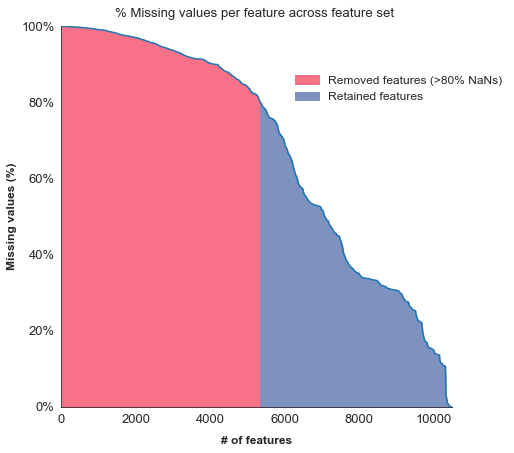

In [29]:
with sns.axes_style("white"):
    
    #isntantiate figure 
    fig, ax = plt.subplots(figsize=(7,7),sharey=True)
    
    #set meta params
    fontsize= 12
    fontweight = "bold"
    th=0.2
    col_options = ['#f77189','#7d92bf']
    visibility = [False,False,True,True]
    spines = ['top','right','left','bottom']
    
    #specify variables
    y = na_df.isna().sum().sort_values(ascending=False)/nrows
    y = y.values
    x = np.arange(1,len(y)+1,1)
    th = sum(y > 0.8)+1
    
    #generate plot 
    ax.plot(x,y)
    ax.fill_between(x[:th],y[:th],color='#f77189')
    ax.fill_between(x[th:],y[th:],color='#7d92bf')
    
    #format plot 
    ax.set_ylabel("Missing values (%)",fontweight=fontweight,fontsize=fontsize)
    ax.set_xlabel("# of features",fontweight=fontweight,fontsize=fontsize,labelpad=10)
    ax.set_title(f"% Missing values per feature across feature set ",fontweight="normal",fontsize=fontsize*1.1,y=1.01)
    ax.set_ylim(0,1)
    ax.set_xlim(0,len(x))
    
    ylabels = ['{0:.0f}%'.format(x*100) for x in ax.get_yticks()]
    ax.set_yticklabels(ylabels)
    
    for idx,p in enumerate(ax.patches):
        width = p.get_width()
        height = p.get_height()
        a,b = p.get_xy() 
        ax.annotate(f'{round(height,2)}', (a + width/2, b + height*1.03), ha='center',color=colors[idx])
    
    frame_zip = zip(spines,visibility)
    for z in frame_zip:
        ax.spines[z[0]].set_visible(z[1])
    
    red_patch = mpatches.Patch(color='#f77189', label='Removed features (>80% NaNs)')
    blue_patch = mpatches.Patch(color='#7d92bf', label='Retained features')
    
    ax.legend(handles=[red_patch,blue_patch],frameon=False,bbox_to_anchor=(0.57, 0.9),prop={'size':12} )
    ax.tick_params(axis = 'both', which = 'major', labelsize = 13)
    
    #plt.savefig("Vis/Fig_1.png")
    plt.show()

### FIGURE  - Plot Continuous & Categorical Feature Invariances 

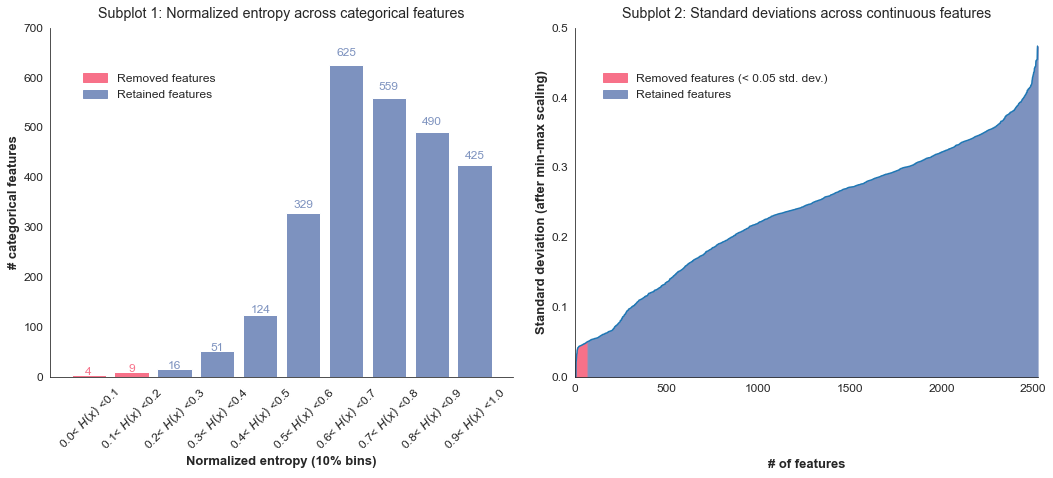

In [32]:
#create dataframe to visualize entropy scores for categorical variables
entro_df = pd.DataFrame(res_df.bin.value_counts()).reset_index()
entro_df["up"] = entro_df["index"].apply(lambda x: x.split("<")[-1])
entro_df.sort_values("up",ascending=True,inplace=True)

with sns.axes_style("white"):
    
    #instantiate figure 
    fig, axes = plt.subplots(1,2,figsize=(15,7))
    axes = axes.ravel()
    
    #define meta params 
    fontsize= 13
    fontweight = "bold"
    th=0.2
    col_options = ['#f77189','#7d92bf']
    colors = ['#f77189' if float(i) <= th  else '#7d92bf' for i in entro_df.up]
    visibility = [False,False,True,True]
    spines = ['top','right','left','bottom']
    
    ############################### Subplot 1:Categorical Features ###############################
    #specify variables
    y = entro_df.bin
    x = np.arange(1,len(y)+1,1)
    
    #generate plot
    axes[0].bar(x,y,alpha=1,color =colors)
    
    #format plot
    axes[0].set_xticks(np.arange(1,len(x)+1,1))
    xlabels = [list(entro_df["index"])[i] for i,_ in enumerate(axes[0].get_xticks())]
    axes[0].set_xticklabels(xlabels)
    axes[0].set_ylim(0,700)
    
    for tick in axes[0].get_xticklabels():
        tick.set_rotation(45)
    
    axes[0].set_ylabel("# categorical features",fontweight=fontweight,fontsize=fontsize)
    axes[0].set_xlabel("Normalized entropy (10% bins)",fontweight=fontweight,fontsize=fontsize)
    axes[0].set_title(f"Subplot 1: Normalized entropy across categorical features",fontweight="normal",fontsize=fontsize*1.1,y=1.01)
    
    for idx,p in enumerate(axes[0].patches):
        width = p.get_width()
        height = p.get_height()
        a,b = p.get_xy() 
        axes[0].annotate(f'{round(height,2)}', (a + width/2, b + height*1.03), ha='center',color=colors[idx],fontsize=12)
    
    frame_zip = zip(spines,visibility)
    for z in frame_zip:
        axes[0].spines[z[0]].set_visible(z[1])
        
    red_patch = mpatches.Patch(color='#f77189', label='Removed features')
    blue_patch = mpatches.Patch(color='#7d92bf', label='Retained features')
    
    axes[0].legend(handles=[red_patch,blue_patch],frameon=False,bbox_to_anchor=(0.38, 0.9),prop={'size':12})
    axes[0].tick_params(axis = 'both', which = 'major', labelsize = 12)
    
    
    ############################### Subplot 2:Continuous Features ###############################
    
    #specify variables
    y = scaled_df.std(skipna=True,axis=0).sort_values(ascending=True)
    y = y.values
    x = np.arange(1,len(y)+1,1)
    th = sum(y < 0.05)+1

    #generate plot 
    axes[1].plot(x,y)
    axes[1].fill_between(x[:th],y[:th],color='#f77189')
    axes[1].fill_between(x[th:],y[th:],color='#7d92bf')

    #formate plot 
    axes[1].set_ylabel("Standard deviation (after min-max scaling)",fontweight=fontweight,fontsize=fontsize)
    axes[1].set_xlabel("# of features",fontweight=fontweight,fontsize=fontsize,labelpad=65)
    axes[1].set_title(f"Subplot 2: Standard deviations across continuous features",fontweight="normal",fontsize=fontsize*1.1,y=1.01)
    axes[1].set_ylim(0,0.5)
    axes[1].set_xlim(0,len(x))
    
    frame_zip = zip(spines,visibility)
    for z in frame_zip:
        axes[1].spines[z[0]].set_visible(z[1])
    
    red_patch = mpatches.Patch(color='#f77189', label='Removed features (< 0.05 std. dev.)')
    blue_patch = mpatches.Patch(color='#7d92bf', label='Retained features')
    
    axes[1].legend(handles=[red_patch,blue_patch],frameon=False,bbox_to_anchor=(0.57, 0.9),prop={'size':12})
    axes[1].tick_params(axis = 'both', which = 'major', labelsize = 12)
    
    fig.tight_layout(pad=2.0)
    #plt.savefig("Vis/Fig_3.png")
    plt.show()

## Create input feature df for train test split 

In [40]:
feature_df = background.copy()
##### Remove columns #######

#Only retain low NA columns 
print(f"df shape BEFORE removal of high NA columns: {feature_df.shape}")
feature_df= feature_df[good_cols]
print(f"df shape AFTER removal of high NA columns: {feature_df.shape}")

#Only retain high var continuous columns 
print(f"df shape BEFORE removal of low var continuous columns: {feature_df.shape}")
feature_df = feature_df.loc[:,feature_df.columns.difference(low_var_cont_cols)]
print(f"df shape AFTER removal of of low var continuous columns: {feature_df.shape}")

#Only retain high var continuous columns 
print(f"df shape BEFORE removal of low var categorical columns: {feature_df.shape}")
feature_df= feature_df.loc[:,feature_df.columns.difference(low_var_cat_cols)]
print(f"df shape AFTER removal of of low var categorical columns: {feature_df.shape}")

#single out all cols classified as categorical
cat_cols = [col for col in feature_df.columns if "CAT_" in col ]

#single out all cols classified as continuous 
cont_cols = [col for col in feature_df.columns if "CONT_" in col ]

#single out continous cols with datatype object 
conflict_cont_cols = [f"CONT_{col}" for col in conflict_cols]

#single out categorical cols with non-numeric dtypes (Note:NAs will be encoded too)
conflict_cat_cols = feature_df.loc[:,[col for col in feature_df.columns if "CAT_" in col]].select_dtypes(include='object').columns 

########## Rectify dtypes ##############

#CATEGORICAL - replace "other" entries with nan 
feature_df.loc[:,conflict_cat_cols]= feature_df.loc[:,conflict_cat_cols].replace("Other",np.nan)
#CONTINUOUS - replace "other" entries with nan > not necessary anymore since cols have been dropped for high NA counts

########## Create Dummies ##############

cont_df = feature_df.loc[:,cont_cols]

def create_binary(df,codename,code):
    s = df.applymap(lambda x : f"{code}" in str(x)).any()
    cols_select = list(s[s].index)
    print(f"{len(cols_select )} binary cols ({codename}: Yes(1)/No(0)) will be derived ...")
    def binarize (cols_select):
        dummies =[]
        for col in cols_select:
            s = df.loc[:,col] == code
            s = s.apply(lambda x: 1 if x == True else 0)
            dummies.append(s)
            
        return pd.concat(dummies, axis='columns').add_suffix('_' + f"{codename}")
    
    res_df = binarize(cols_select)  
    
    res_cols = [f'DER_{col.split("CONT_")[-1]}' for col in res_df.columns]
    res_df.columns = res_cols
    
    return res_df   

#create dummy variables for missing codes "-1" and "-2" as suggested by literature
cont_refusal = create_binary(cont_df,"refusal",-1)
cont_dontknow = create_binary(cont_df,"dontknow",-2)

### Fetch Missingness Code Distribution AFTER column pruning

tot_missing_after, var_missing_after = investigate_missingness (feature_df,verbose=True)

########## Replace missing codes for continuous with NA ##############

#replace all missing codes (-1 to -9) with NaN in original columns
mask = cont_df.loc[:,cont_cols] < 0
cont_df[mask] = np.nan

cat_df_num = feature_df.loc[:,cat_cols].select_dtypes(exclude="object")
mask = cat_df_num < 0 
cat_df_num[mask] = np.nan

#Note: no nan replacement needed since no missingness codes in string cols
cat_df_str = feature_df.loc[:,cat_cols].select_dtypes(include="object")

########## Combine into single df ##############

feature_df = pd.concat([cont_df,cont_refusal,cont_dontknow,cat_df_num,cat_df_str],axis="columns")

var_dict = defaultdict(int)
for col in feature_df.columns:
    
    if "CAT_" in col:
        var_dict["categorical vars"] +=1
    
    if any([fix in col for fix in ["_refusal","_dontknow"]]):
        var_dict["derived vars"] +=1
        
    if "CONT_" in col:
        var_dict["continuous vars"] +=1

print("="*3 + "Variables in final df prior to train test split"+"="*3)
for k,v in var_dict.items():
    print(f"{k}: {v}")
    
print("="*3 + "Shape of modified background df passed to train-test split"+"="*3)
print(f"# Rows: {feature_df.shape[0]} # Cols {feature_df.shape[1]}")

df shape BEFORE removal of high NA columns: (4242, 10500)
df shape AFTER removal of high NA columns: (4242, 5156)
df shape BEFORE removal of low var continuous columns: (4242, 5156)
df shape AFTER removal of of low var continuous columns: (4242, 5091)
df shape BEFORE removal of low var categorical columns: (4242, 5091)
df shape AFTER removal of of low var categorical columns: (4242, 5078)
1367 binary cols (refusal: Yes(1)/No(0)) will be derived ...
1681 binary cols (dontknow: Yes(1)/No(0)) will be derived ...
0 variables checked for missingness... 
2000 variables checked for missingness... 
4000 variables checked for missingness... 
===Variables in final df prior to train test split===
continuous vars: 2459
derived vars: 3048
categorical vars: 2619
===Shape of modified background df passed to train-test split===
# Rows: 4242 # Cols 8126


## Write out pre-processed data and dtype dictionary

In [41]:
#write out pruned feature and dtype dict
dtype_dict = dict(feature_df.dtypes)

#################################################################################################################################
##PLEASE NOTE: DO NOT CHANGE FILE PATH data is written to unless you adapt the import statement in the 2nd Jupyter Notebook!!!###
#################################################################################################################################

feature_df.to_csv('FFChallenge_v5/background_pruned.csv',index=True)

with open('dtype_dict.pickle', 'wb') as handle:
    pickle.dump(dtype_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('dtype_dict.pickle', 'rb') as handle:
    test = pickle.load(handle)
    
print(f"Pickle file equals dict : {test==dtype_dict}")

test = pd.read_csv('FFChallenge_v5/background_pruned.csv', sep=',',dtype=dtype_dict,header=0, index_col=0,float_precision='high')

_,_ = similarity_check (test,feature_df)

Pickle file equals dict : True
df1 and df2 are equal: True
all dtype match: True
Col-level appraisal: 289 inconsistencies due to floating point inprecision


True     7837
False     289
dtype: int64

### FIGURE - Missing Label Distribution (Before vs. After Column Pruning)

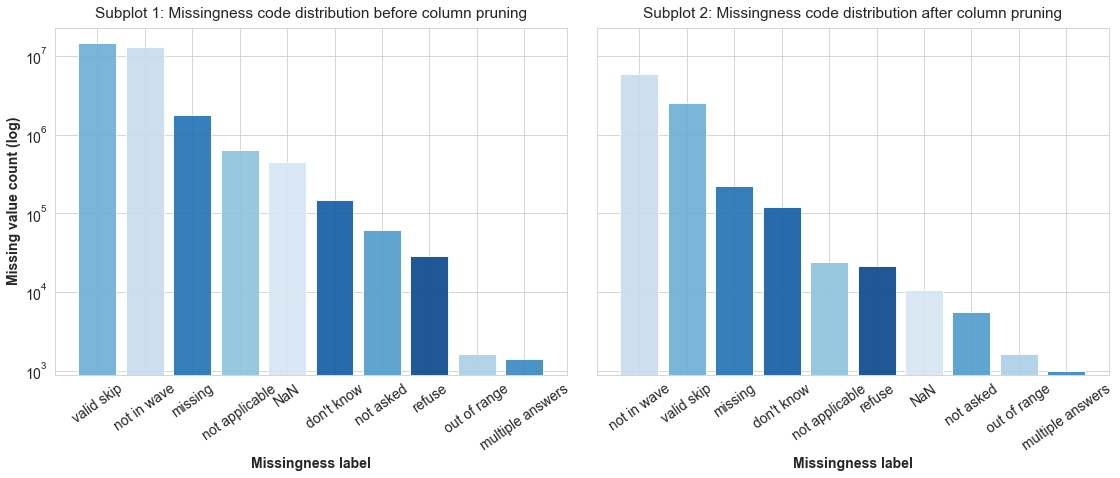

In [42]:
### Figure - Missingness Code Distribution BEFORE and AFTER column pruning ###
missing_codes = [-1.0,-2.0,-3.0,-4.0,-5.0,-6.0,-7.0,-8.0,-9.0,"NaN"]
missing_code_names = ["refuse", "don't know", "missing", "multiple answers","not asked", "valid skip", "not applicable", "out of range", "not in wave","NaN"]
colors = ['#08468b', '#105ba4', '#2171b5', '#3787c0', '#4f9bcb', '#6caed6', '#8dc1dd', '#abd0e6', '#c7dbef', '#d6e6f4']
state = ["before","after"]

#create look-up dicts 
missing_dict = {k:v for k,v in zip(missing_codes,missing_code_names)}
color_dict = {k:v for k,v in zip(missing_codes,colors)}


with sns.axes_style("whitegrid"):
    
    #instantiate figure 
    fig, axes = plt.subplots(1,2,figsize=(16,7),sharey=True)
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.05, hspace=None)

    axes = axes.ravel()
    
    fontsize= 14
    fontweight = "bold"
    
    for idx, df in enumerate([tot_missing_before,tot_missing_after]):
        
        #condition data for plotting 
        missing_df = pd.DataFrame.from_dict(df.most_common())
        missing_df["label"] = missing_df[0].replace(missing_dict)
        missing_df["color"] = missing_df[0].replace(color_dict)
        
        x = np.arange(1,len(missing_df)+1,1)
        y = missing_df[1]
        
        #generate plot 
        axes[idx].bar(x,y,color = missing_df["color"].tolist(),alpha=0.9)
        
        #format plot 
        axes[idx].set_xticks(np.arange(1,len(x)+1,1))
        xlabels = [list(missing_df["label"])[i] for i,_ in enumerate(axes[0].get_xticks())]
        axes[idx].set_xticklabels(xlabels)
        axes[idx].get_yaxis().set_major_formatter(mticker.FuncFormatter(lambda x, p: format(int(x), ',')))
        
        if idx ==1:
            axes[idx].set_ylabel("",fontweight=fontweight,fontsize=fontsize)
        else:
            axes[idx].set_ylabel("Missing value count (log)",fontweight=fontweight,fontsize=fontsize)
        axes[idx].set_xlabel("Missingness label",fontweight=fontweight,fontsize=fontsize)
        axes[idx].set_title(f"Subplot {idx+1}: Missingness code distribution {state[idx]} column pruning",fontweight="normal",fontsize=fontsize*1.1,y=1.01)
        
        axes[idx].set_yscale("log")
        
        for tick in axes[idx].get_xticklabels():
            tick.set_rotation(35)
        
        axes[idx].tick_params(axis="x", labelsize=12)
        axes[idx].tick_params(axis="y", labelsize=12)
        axes[idx].tick_params(axis = 'both', which = 'major', labelsize = 14)
    
    fig.tight_layout(pad=2.0)
    #plt.savefig("Vis/Fig_2.png")
    plt.show()

### FIGURE - Overview of Feature Engineering before train-test split

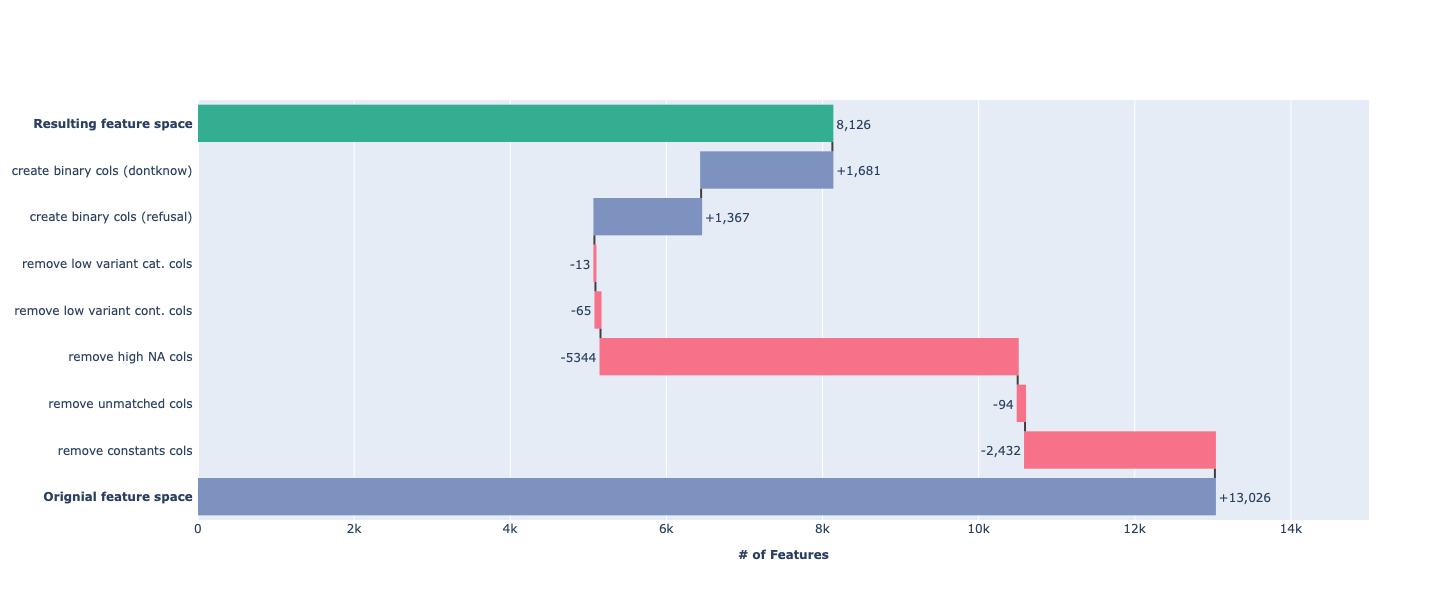

In [43]:
##PLEASE NOTE: PLOT MIGHT NOT RUN unless you have necessary plotly libraries installed

#define data points
raw_base = 13026
invar_rem = 10594-13026
no_map_rem = 10500-10594
na_rem = 5156-10500
lv_cont_rem = 5091-5156
lv_cat_rem = 5078-5091
bin_ref = cont_refusal.shape[1]
bin_dk = cont_dontknow.shape[1]
total = feature_df.shape[1]

#create plot
fig = go.Figure(go.Waterfall(
    orientation = "h",
    measure = ["relative", "relative", "relative", "relative", "relative", "relative","relative","relative","total"],
    y = ["<b>Orignial feature space</b> ",
    "remove constants cols ",
    "remove unmatched cols ",
    "remove high NA cols ",
    "remove low variant cont. cols ",
    "remove low variant cat. cols ",
    "create binary cols (refusal) ",
    "create binary cols (dontknow) ",
         "<b>Resulting feature space</b> "],
    text=['+13,026', '-2,432', '-94', '-5344', '-65', '-13', '+1,367', '+1,681', '8,126'],
    textposition = "outside",
    decreasing = {"marker":{"color":"#f77189"}},
    increasing = {"marker":{"color":"#7d92bf"}},
    totals = {"marker":{"color":'#34ae91'}},
    x = [raw_base,invar_rem,no_map_rem,na_rem,lv_cont_rem,lv_cat_rem,bin_ref,bin_dk,total],
    connector = {"line":{"color":"rgb(63, 63, 63)"}},
))

#format plot 
fig.update_layout(
        title = None,width=800, height=600,
        xaxis=dict(title="<b># of Features</b>",titlefont = dict(size=12))
        
)
fig.update_xaxes(range=[0, 15000])

fig.show()
#fig.write_image("Vis/Fig_4.png",scale=1)